# Paleogeographic analysis of large igneous provinces

This Jupyter notebook contains analysis associated with:

XXX

## Import necessary modules

This code is written in Python 2.7 using the following python modules that can be installed via pip or conda:
- pandas XXX
- numpy XXX
- matplotlib XXX
- cartopy XXX
- shapely XXX
- netCDF4 XXX

The full computational environment associated with these modules can be found within the XXX file in this repository. In addition, the code imports and uses custom python functions that are included within this repository as recon_tools.py. The implementation of this analysis relies heavily on functions within pygplates http://www.gplates.org/docs/pygplates/index.html. The pygplates code is compatible with Python 2, which is why this code is in Python 2 rather than 3.

In [1]:
# standard modules
import numpy as np
from numpy.core.umath_tests import inner1d
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# pygplates
import pygplates

# cartopy
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Polygon

# cartopy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# netCDF
#from netCDF4 import Dataset

# recon_tools
from recon_tools import *

/Users/yuempark/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  This is separate from the ipykernel package so we can avoid doing imports until


## Read In Files

The following code imports these files:

* `LIP_feature_collection` : a shapefile containing polygons for the inferred eruptive extent of large igneous provinces, modified slightly from the compilation of Ernst and Youbi (2017). Included within the shapefile attributes are:
    1. The emplacement ages of each of the LIPs, obtained from various sources in the literature
    2. the plate ID's used to associated each LIP with a continental polygon block in the CEED 6 model
* `craton_feature_collection` : continental polygon blocks from the CEED6 model used in Torsvik and Cocks (2017) with the addition of the Domeier (2018) Kazakh polygons
* `model` : Torsvik and Cocks (2017) model that is modified by:
    1. implementing the Swanson-Hysell and Macdonald (2017) Ordovician modification for Laurentia based on high-quality paleomagnetic data from allochthonous terranes
    2. adjustments of the early Paleozoic paleogeography of Asia made by Domeier (2018). These adjustments include the addition of ‘North Tianshan’ and ‘Boshekul-Chingiz’ zone rotation parameters so that sutures in the Kazakh terranes can be reconstructed as well as adjustments for North China, South China, Siberia and Tarim.

In [2]:
# change this root to the dropbox folder
root = '/Users/yuempark/Dropbox/Ophiolite_Compilation/'

LIP_feature_collection = pygplates.FeatureCollection.read(root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/LIP_Outline_edited.shp')
craton_feature_collection = pygplates.FeatureCollection.read(root+'Paleogeo_models/CEED6/CEED6_POLY.shp')
model = root+'Paleogeo_models/TC2017_SHM2017_D2018.rot'

In [3]:
ice = pd.read_csv('../Data/Ice_Extent.csv')

## Analysis Function

This function calculates the total area of LIPs in each latitude band for any given time slice. The calculations perfomed include:

* areas without any post-emplacement scenario applied
* areas that decay exponentially with a specified half-life after emplacement
* areas that decay exponentially with a specified half-life after emplacement, although with removal of specified LIPs that have been deemed to be associated with successful rifting and subsidence

In [4]:
def get_LIP_areas_in_bands(reconstructed_feature_geometries, lat_mins, lat_maxs,
                           halflife, cover_removal, cover_halflife):
    """
    Get the area of all LIP features in each latitude band, with additional calculations for:
    - scenario (A) features decaying exponentially
    - scenatio (B) covered features disappearing and other features decaying exponentially

    Parameters
    ----------
    reconstructed_feature_geometries : list
        list of reconstructed features output from a pygplates reconstruction
        
    lat_mins : array
        array of latitude minimums of each latitude band
        
    lat_maxs : array
        array of latitude maximums of each latitude band
        
    halflife : array
        half-lives of exponential decay for scenario (A) - if multiple values are provided, multiple scenario (A)s
        will be calculated
        
    cover_removal : list of booleans
        if True, instantly remove, if False, remove 50% instantly for scenario (B) - if multiple values are
        provided, multiple scenario (B)s will be calculated. The length of this list must match the length of
        'cover_halflife'
        
    cover_halflife : array
        half-lives of exponential decay for the uncovered features in scenario (B) - if multiple values are
        provided, multiple scenario (B)s will be calculated. The length of this array must match the length of
        'cover_removal'

    Returns
    -------
    areas : array
        list of total area in each latitude band
        
    area_polygons : list of polygons
        list of all sliced polygons for which areas were calculated
        
    areas_decay : list of arrays
        each array contains the total area in each latitude band under scenario (A) - one array per value
        provided in 'halflife'
        
    areas_cover : list of arrays
        each array contains the total area in each latitude band under scenario (B) - one array per value
        provided in 'cover_removal' and 'cover_halflife'
    """
    # storage vectors
    areas = np.array([])
    area_polygons = []
    areas_decay_temp = []
    areas_cover_temp = []
    
    # convert halflives to decay constants
    lamb = np.log(2)/halflife
    cover_lamb = np.log(2)/cover_halflife

    # iterate over each latitude band
    for i in range(len(lat_mins)):

        # this float stores the total LIP area within the latitude band
        accumulated_area = 0

        # these arrays store the total LIP area within the latitude band under scenarios A and B
        # one element per value provided in 'halflife' for scenario A
        # one element per value provided in 'cover_removal' and 'cover_halflife' for scenario B
        accumulated_area_decay = np.zeros(len(halflife))
        accumulated_area_cover = np.zeros(len(cover_halflife))

        # iterate over each polygon
        for j in range(len(reconstructed_feature_geometries)):

            # get the eruption age, reconstruction age, feature age, feature name, and feature ID
            begin_date, end_date = reconstructed_feature_geometries[j].get_feature().get_valid_time()
            now_date = reconstructed_feature_geometries[j].get_reconstruction_time()
            feature_age = begin_date - now_date
            feature_name = reconstructed_feature_geometries[j].get_feature().get_name()
            feature_Id = reconstructed_feature_geometries[j].get_feature().get_feature_id().get_string()

            # get the actual polygon
            current_polygon = reconstructed_feature_geometries[j].get_reconstructed_geometry()

            # check if the polygon is in the band
            in_band = check_polygon_in_band(current_polygon, lat_mins[i], lat_maxs[i])

            # only perform the calculations if the polygon is within the latitude band
            if in_band:
                
                # do the calculation
                area, band_polygon = get_area_in_band(current_polygon, lat_mins[i], lat_maxs[i])

                # store results
                # for the scenario which does not implement any post-emplacement scenario, only add the area
                # if the LIP erupted after 520 Ma
                if begin_date<=520:
                    accumulated_area = accumulated_area + area
                area_polygons.append(band_polygon)

                # decay method (scenario A)
                for k in range(len(halflife)):
                    
                    # scale the area based on the exponential decay equation
                    decay_area = area * np.exp(-lamb[k]*feature_age)
                    accumulated_area_decay[k] = accumulated_area_decay[k] + decay_area
                        
                # cover method (scenario B)
                # check to see whether we deem the LIP to be covered
                if feature_name in covered_LIP_names:
                    for k in range(len(cover_halflife)):
                        
                        # complete and instant removal
                        if cover_removal[k]:
                            pass
                        
                        # 50% instant removal - the rest decays exponentially 
                        else:
                            decay_area = area/2 * np.exp(-cover_lamb[k]*feature_age)
                            accumulated_area_cover[k] = accumulated_area_cover[k] + decay_area
                            
                # uncovered LIPs
                else:
                    for k in range(len(cover_halflife)):
                        
                        # scale the area based on the exponential decay equation
                        decay_area = area * np.exp(-cover_lamb[k]*feature_age)
                        accumulated_area_cover[k] = accumulated_area_cover[k] + decay_area
                        
        # store total area for the band
        areas = np.append(areas, accumulated_area)
        areas_decay_temp.append(accumulated_area_decay)
        areas_cover_temp.append(accumulated_area_cover)

    # flip our outputs so that each array in our list is for a given input/halflife
    areas_decay = []
    for i in range(len(halflife)):
        this_array = np.array([])
        for j in range(len(areas_decay_temp)):
            this_array = np.append(this_array, areas_decay_temp[j][i])
        areas_decay.append(this_array)
    areas_cover = []
    for i in range(len(cover_halflife)):
        this_array = np.array([])
        for j in range(len(areas_cover_temp)):
            this_array = np.append(this_array, areas_cover_temp[j][i])
        areas_cover.append(this_array)

    # return necessary variables
    return areas, area_polygons, areas_decay, areas_cover

## Demonstration of Method

To illustrate how the LIP zonal areas are calculated using this code, below is a demonstration of the method for a single time slice at 40 Ma.

First, we set up the latitude bands that we will be summing areas over:

In [5]:
# band_width must be a factor of 90
band_width = 5
lat_mins = np.arange(-90           , 90           , band_width)
lat_maxs = np.arange(-90+band_width, 90+band_width, band_width)
lat_mids = lat_mins + (lat_maxs-lat_mins)/2

Next, we perform the paleogeographic reconstruction for 40 Ma using pygplates:

In [6]:
# input parameters
t = 40     #reconstruction time
anchor = 1  #anchor plate ID

# carry out the reconstruction for the cratons
reconstructed_cratons = []
pygplates.reconstruct(craton_feature_collection, model, reconstructed_cratons, t, anchor)

# carry out the reconstruction for the LIPs
reconstructed_LIPs = []
pygplates.reconstruct(LIP_feature_collection, model, reconstructed_LIPs, t, anchor)

Plot the reconstructed cratons and LIPs:

In [7]:
# suppress warning associated with polygon plotting
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

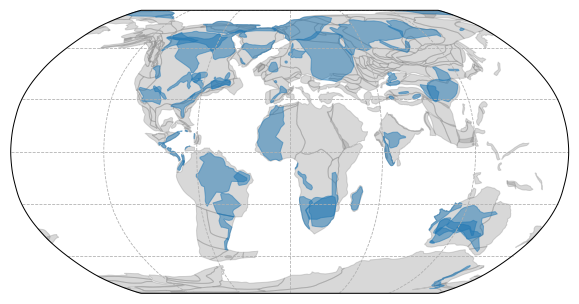

In [8]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.Robinson()))
ax.set_global()
ax.gridlines(xlocs=np.arange(-180,181,60),ylocs=np.arange(-90,91,30),linestyle='--')

# add the polygons
plot_reconstructed_features(ax, reconstructed_cratons, color='grey', alpha=0.3)
plot_reconstructed_features(ax, reconstructed_LIPs, color='C0', alpha=0.5)

Calculate the area of reconstructed cratons and LIPs within each of the latitude bands defined above:

In [9]:
# perform the calculations for cratons
areas_cratons, area_polygons_cratons = get_areas_in_bands(reconstructed_cratons, lat_mins, lat_maxs)

# perform the calculations for LIPs
areas_LIPs, area_polygons_LIPs = get_areas_in_bands(reconstructed_LIPs, lat_mins, lat_maxs)

Plot the calculated zonal areas:

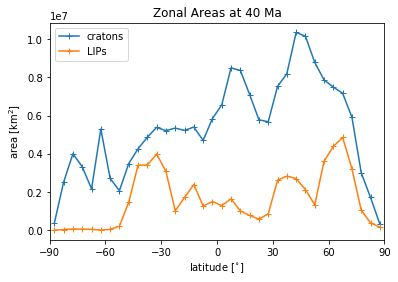

In [10]:
# define column names
cols = ['area_km2','minimum_latitude','maximum_latitude']

# set up dataframes with the calculated zonal areas and their latitude bands
df_cratons = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_cratons})
df_cratons = df_cratons[cols]

df_LIPs = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_LIPs})
df_LIPs = df_LIPs[cols]

# plot
fig, ax = plt.subplots()
ax.plot((df_cratons['minimum_latitude']+(df_cratons['maximum_latitude']-df_cratons['minimum_latitude'])/2),
        df_cratons['area_km2'], '+-', c='C0', label='cratons')
ax.plot((df_LIPs['minimum_latitude']+(df_LIPs['maximum_latitude']-df_LIPs['minimum_latitude'])/2),
        df_LIPs['area_km2'], '+-', c='C1', label='LIPs')
ax.set_xlabel('latitude [$^{\circ}$]')
ax.set_ylabel('area [km$^{2}$]')
ax.set_xlim(-90,90)
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_title('Zonal Areas at 40 Ma')
ax.legend()
plt.show(fig)

Do a reality check to make sure that our calculated craton areas are reasonable:

In [11]:
print('relative to area of exposed land (Coble et al., 1987) : {:.2f}'.format(np.sum(df_cratons['area_km2'])/148.3e6))
print('relative to area of continental crust (Cogley, 1984)  : {:.2f}'.format(np.sum(df_cratons['area_km2'])/2.1e8))

relative to area of exposed land (Coble et al., 1987) : 1.30
relative to area of continental crust (Cogley, 1984)  : 0.92


## Calculations over the Phanerozoic

Here, we apply the method illustrated above for 545 Ma to the present.

Note that the paleogeographic model is valid from 550 Ma onwards.

### Calculation Set Up

Set up the model:

In [12]:
# create the latitude bands
# band_width must be a factor of 90
band_width = 5
lat_mins = np.arange(-90           , 90           , band_width)
lat_maxs = np.arange(-90+band_width, 90+band_width, band_width)
lat_mids = lat_mins + (lat_maxs-lat_mins)/2

# time resolution
t_step = -5

# anchor plate ID
anchor = 1

# set up the time vector
t_start = 545
t_stop = 0
ts = np.arange(t_start, t_stop+t_step, t_step)

Specify which post-emplacement scenarios we would like to run:

In [13]:
# the halflife for exponential decay
halflife = [36, 120]

# the halflife for exponential decay
cover_removal = [False, False, True, True]
cover_halflife = [36, 120, 36, 120]

Specify which LIPs are associated with successful rifting and subsidence:

In [14]:
# the previous version
#covered_LIP_names = ['Parana-Etendeka',
#                     'CAMP',
#                     'Wichita',
#                     'NAIP',
#                     'Madagascar',
#                     'Maud Rise',
#                     'Seychelles',
#                     'NW-Australian margin']

# new version
covered_LIP_names = ['Keweenawan',
                     'Wichita',
                     'CAMP',
                     'NW Australia Margin',
                     'Parana-Etendeka',
                     'Seychelles',
                     'North Atlantic',
                     'Afar']

silicic_LIP_names = ['Sierra Madre Occidental',
                     'Whitsunday',
                     'Chon Aike',
                     'Kennedy-Conners-Auburn',
                     'Ouarzazate']

### Perform Calculations

The calculations take some time to perform (~30 minutes) - in order to save some time, the following boolean sets whether the calculations are performed (True), or whether we read in the last set of calculations (False) for the cases in which we just want to visualize/analyze the results. In most cases, we only want to set `refresh` to True if we are somehow changing the calculation:

In [15]:
refresh = False

Now perform the calculations:

In [16]:
# perform the calculations if we set it to above
if refresh:
    
    # get the unique ID and name associated with each LIP geometry
    LIP_Ids = []
    LIP_names = []
    LIP_begins = []
    LIP_areas = []
    for feature in LIP_feature_collection:
        LIP_Id = feature.get_feature_id().get_string()
        LIP_Ids.append(LIP_Id)
        LIP_name = feature.get_name()
        LIP_names.append(LIP_name)
        LIP_begin, LIP_end = feature.get_valid_time()
        LIP_begins.append(LIP_begin)
        LIP_area = feature.get_geometry().get_area() * 6371.009**2
        LIP_areas.append(LIP_area)
        
    # store those properties in a dataframe
    LIP_properties = pd.DataFrame({'Ids':LIP_Ids,'names':LIP_names,'begins':LIP_begins,'areas':LIP_areas})
    
    # initialize storage dataframes
    areas_cratons_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_decay1_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_decay2_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_cover1_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_cover2_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_cover3_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_cover4_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    centroid_lat_LIPs_df = pd.DataFrame({'LIP_Ids':LIP_Ids,'LIP_names':LIP_names})
    centroid_lon_LIPs_df = pd.DataFrame({'LIP_Ids':LIP_Ids,'LIP_names':LIP_names})

    # iterate through the time vector
    for i in range(len(ts)):

        # carry out the reconstruction for the cratons and LIPs
        reconstructed_cratons = []
        pygplates.reconstruct(craton_feature_collection, model, reconstructed_cratons, ts[i], anchor)
        reconstructed_LIPs = []
        pygplates.reconstruct(LIP_feature_collection, model, reconstructed_LIPs, ts[i], anchor)

        # perform the zonal area calculations for the cratons
        areas_cratons, area_polygons_cratons = get_areas_in_bands(reconstructed_cratons, lat_mins, lat_maxs)
        
        # perform the zonal area calculations for the LIPs using the function defined above
        areas_LIPs,area_polygons_LIPs,areas_LIPs_decay,areas_LIPs_cover =\
            get_LIP_areas_in_bands(reconstructed_LIPs,lat_mins,lat_maxs,
                                   halflife,cover_removal,cover_halflife)

        # store results
        areas_cratons_df['area_km2_' + str(ts[i])] = areas_cratons
        areas_LIPs_df['area_km2_' + str(ts[i])] = areas_LIPs
        areas_LIPs_decay1_df['area_km2_' + str(ts[i])] = areas_LIPs_decay[0]
        areas_LIPs_decay2_df['area_km2_' + str(ts[i])] = areas_LIPs_decay[1]
        areas_LIPs_cover1_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[0]
        areas_LIPs_cover2_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[1]
        areas_LIPs_cover3_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[2]
        areas_LIPs_cover4_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[3]
        
        # get centroids
        for j in range(len(reconstructed_LIPs)):
            LIP_Id = reconstructed_LIPs[j].get_feature().get_feature_id().get_string()
            current_LIP = reconstructed_LIPs[j].get_reconstructed_geometry()
            centroid_point = current_LIP.get_interior_centroid()
            centroid_lat = centroid_point.to_lat_lon_array()[0][0]
            centroid_lon = centroid_point.to_lat_lon_array()[0][1]
            
            # store
            for k in range(len(centroid_lat_LIPs_df.index)):
                if centroid_lat_LIPs_df['LIP_Ids'][k] == LIP_Id:
                    centroid_lat_LIPs_df.loc[k,'lat_' + str(ts[i])] = centroid_lat
                    centroid_lon_LIPs_df.loc[k,'lon_' + str(ts[i])] = centroid_lon
                    break
        
    # save results to csv's    
    areas_cratons_df.to_csv('reconstruction_output/areas_cratons_df.csv', index=False)
    areas_LIPs_df.to_csv('reconstruction_output/areas_LIPs_df.csv', index=False)
    areas_LIPs_decay1_df.to_csv('reconstruction_output/areas_LIPs_decay1_df.csv', index=False)
    areas_LIPs_decay2_df.to_csv('reconstruction_output/areas_LIPs_decay2_df.csv', index=False)
    areas_LIPs_cover1_df.to_csv('reconstruction_output/areas_LIPs_cover1_df.csv', index=False)
    areas_LIPs_cover2_df.to_csv('reconstruction_output/areas_LIPs_cover2_df.csv', index=False)
    areas_LIPs_cover3_df.to_csv('reconstruction_output/areas_LIPs_cover3_df.csv', index=False)
    areas_LIPs_cover4_df.to_csv('reconstruction_output/areas_LIPs_cover4_df.csv', index=False)
    centroid_lat_LIPs_df.to_csv('reconstruction_output/centroid_lat_LIPs_df.csv', index=False)
    centroid_lon_LIPs_df.to_csv('reconstruction_output/centroid_lon_LIPs_df.csv', index=False)
    LIP_properties.to_csv('reconstruction_output/LIP_properties.csv', index=False)
   
# otherwise, we simply read in the previous set of calculations
else:
    areas_cratons_df = pd.read_csv('reconstruction_output/areas_cratons_df.csv')
    areas_LIPs_df = pd.read_csv('reconstruction_output/areas_LIPs_df.csv')
    areas_LIPs_decay1_df = pd.read_csv('reconstruction_output/areas_LIPs_decay1_df.csv')
    areas_LIPs_decay2_df = pd.read_csv('reconstruction_output/areas_LIPs_decay2_df.csv')
    areas_LIPs_cover1_df = pd.read_csv('reconstruction_output/areas_LIPs_cover1_df.csv')
    areas_LIPs_cover2_df = pd.read_csv('reconstruction_output/areas_LIPs_cover2_df.csv')
    areas_LIPs_cover3_df = pd.read_csv('reconstruction_output/areas_LIPs_cover3_df.csv')
    areas_LIPs_cover4_df = pd.read_csv('reconstruction_output/areas_LIPs_cover4_df.csv')
    centroid_lat_LIPs_df = pd.read_csv('reconstruction_output/centroid_lat_LIPs_df.csv')
    centroid_lon_LIPs_df = pd.read_csv('reconstruction_output/centroid_lon_LIPs_df.csv')
    LIP_properties = pd.read_csv('reconstruction_output/LIP_properties.csv')
    
    # get the new unique ID associated with each LIP geometry
    # this unique ID associated with each LIP changes each time the LIP shapefiles are read by pygplates
    # however, the LIPs are always read in the same order, so we can simply update the IDs as follows
    LIP_Ids = []
    for feature in LIP_feature_collection:
        LIP_Id = feature.get_feature_id().get_string()
        LIP_Ids.append(LIP_Id)
        
    # assign the new feature IDs to the old data
    centroid_lat_LIPs_df['LIP_Ids'] = LIP_Ids
    centroid_lon_LIPs_df['LIP_Ids'] = LIP_Ids
    
    LIP_properties['Ids'] = LIP_Ids
    
    print('CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.')

CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.


Now convert the results to absolute latitude:

In [17]:
# perform the calculations if we set it to above
if refresh:
    
    # initiate a new dataframe for absolute latitudes
    num_bands = len(areas_cratons_df.index)

    abs_areas_cratons_df = pd.DataFrame({'lat_maxs':areas_cratons_df['lat_maxs'][(num_bands/2):],
                                         'lat_mids':areas_cratons_df['lat_mids'][(num_bands/2):],
                                         'lat_mins':areas_cratons_df['lat_mins'][(num_bands/2):]})
    abs_areas_cratons_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_df = pd.DataFrame({'lat_maxs':areas_LIPs_df['lat_maxs'][(num_bands/2):],
                                      'lat_mids':areas_LIPs_df['lat_mids'][(num_bands/2):],
                                      'lat_mins':areas_LIPs_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_decay1_df = pd.DataFrame({'lat_maxs':areas_LIPs_decay1_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_decay1_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_decay1_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_decay1_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_decay2_df = pd.DataFrame({'lat_maxs':areas_LIPs_decay2_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_decay2_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_decay2_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_decay2_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_cover1_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover1_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover1_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover1_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover1_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_cover2_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover2_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover2_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover2_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover2_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_cover3_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover3_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover3_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover3_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover3_df.reset_index(drop=True, inplace=True)
    
    abs_areas_LIPs_cover4_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover4_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover4_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover4_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover4_df.reset_index(drop=True, inplace=True)

    # iterate over the time steps
    for i in range(len(ts)):
        
        # iterate over the latitude bands, summing and storing
        for j in range(num_bands/2):
            abs_area = areas_cratons_df['area_km2_'+str(ts[i])][j]+\
                       areas_cratons_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_cratons_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_decay1_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_decay1_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_decay1_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_decay2_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_decay2_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_decay2_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_cover1_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover1_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover1_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_cover2_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover2_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover2_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_cover3_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover3_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover3_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area
            
            abs_area = areas_LIPs_cover4_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover4_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover4_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area
            
    # save results to csv's    
    abs_areas_cratons_df.to_csv('reconstruction_output/abs_areas_cratons_df.csv', index=False)
    abs_areas_LIPs_df.to_csv('reconstruction_output/abs_areas_LIPs_df.csv', index=False)
    abs_areas_LIPs_decay1_df.to_csv('reconstruction_output/abs_areas_LIPs_decay1_df.csv', index=False)
    abs_areas_LIPs_decay2_df.to_csv('reconstruction_output/abs_areas_LIPs_decay2_df.csv', index=False)
    abs_areas_LIPs_cover1_df.to_csv('reconstruction_output/abs_areas_LIPs_cover1_df.csv', index=False)
    abs_areas_LIPs_cover2_df.to_csv('reconstruction_output/abs_areas_LIPs_cover2_df.csv', index=False)
    abs_areas_LIPs_cover3_df.to_csv('reconstruction_output/abs_areas_LIPs_cover3_df.csv', index=False)
    abs_areas_LIPs_cover4_df.to_csv('reconstruction_output/abs_areas_LIPs_cover4_df.csv', index=False)
    
# otherwise, we simply read in the previous set of calculations
else:
    abs_areas_cratons_df = pd.read_csv('reconstruction_output/abs_areas_cratons_df.csv')
    abs_areas_LIPs_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_df.csv')
    abs_areas_LIPs_decay1_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_decay1_df.csv')
    abs_areas_LIPs_decay2_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_decay2_df.csv')
    abs_areas_LIPs_cover1_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_cover1_df.csv')
    abs_areas_LIPs_cover2_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_cover2_df.csv')
    abs_areas_LIPs_cover3_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_cover3_df.csv')
    abs_areas_LIPs_cover4_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_cover4_df.csv')
    
    print('CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.')

CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.


## Visualization and Analysis

### Total Area

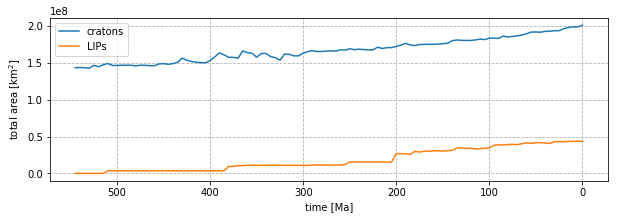

In [18]:
# calculate the total area at each time step
total_area_cratons = []
for i in range(len(ts)):
    area = sum(areas_cratons_df['area_km2_' + str(ts[i])])
    total_area_cratons.append(area)
    
total_area_LIPs = []
for i in range(len(ts)):
    area = sum(areas_LIPs_df['area_km2_' + str(ts[i])])
    total_area_LIPs.append(area)
    
# plot
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(ts, total_area_cratons, c='C0', label='cratons')
ax.plot(ts, total_area_LIPs, c='C1', label='LIPs')
ax.set_ylabel('total area [km$^{2}$]')
ax.set_xlabel('time [Ma]')
ax.legend()
ax.invert_xaxis()
ax.grid(ls='--')
plt.show(fig)

### Zonal Distribution

In [19]:
def plot_contourf(df):
    fig, ax = plt.subplots(figsize=(16,5))

    just_values = df.values[:,3:]

    levels = np.linspace(np.min(just_values),np.max(just_values),15)

    cntrf = ax.contourf(ts, df['lat_mids'], just_values, cmap='viridis', levels=levels)

    ax.set_ylabel('latitude [$^{\circ}$]')
    ax.set_yticks([-90,-45,0,45,90])

    ax.set_xlabel('age [Ma]')
    ax.invert_xaxis()

    cbar = fig.colorbar(cntrf, ax=ax)
    cbar.ax.set_ylabel('area [km$^{2}$]')

    plt.show(fig)

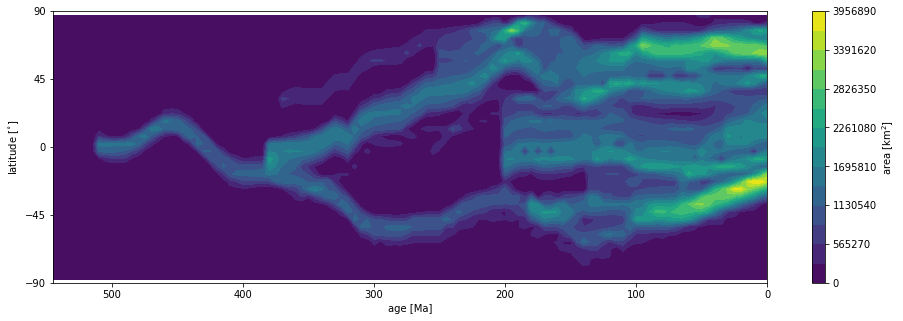

In [20]:
plot_contourf(areas_LIPs_df)

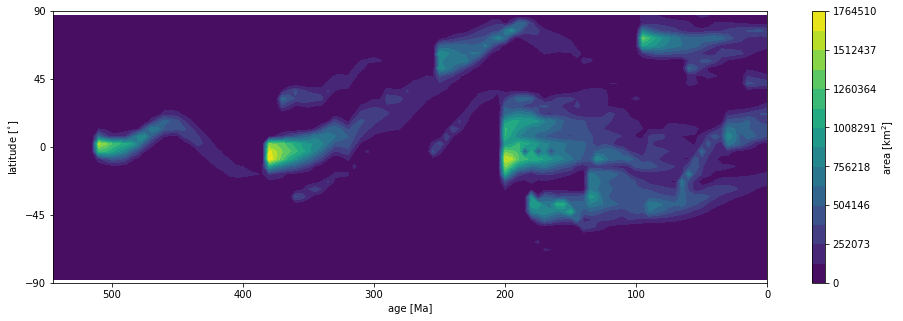

In [21]:
plot_contourf(areas_LIPs_decay1_df)

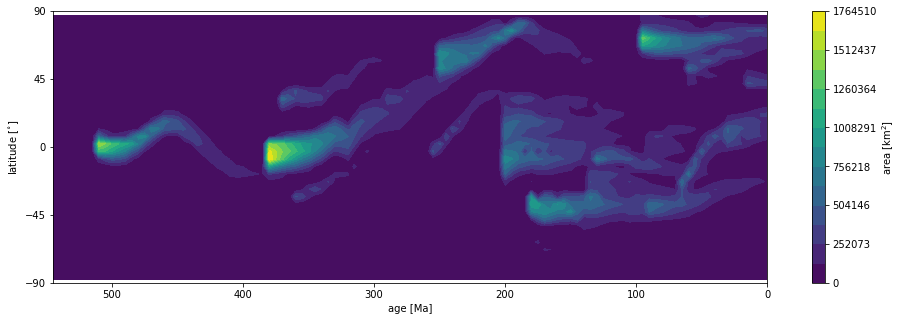

In [22]:
plot_contourf(areas_LIPs_cover1_df)

In [23]:
def plot_abs_contourf(df):
    fig, ax = plt.subplots(figsize=(16,5))

    just_values = df.values[:,3:]

    levels = np.linspace(np.min(just_values),np.max(just_values),15)

    cntrf = ax.contourf(ts, df['lat_mids'], just_values, cmap='viridis', levels=levels)

    ax.set_ylabel('latitude [$^{\circ}$]')
    ax.set_yticks([0,30,60,90])

    ax.set_xlabel('age [Ma]')
    ax.invert_xaxis()

    cbar = fig.colorbar(cntrf, ax=ax)
    cbar.ax.set_ylabel('area [km$^{2}$]')

    plt.show(fig)

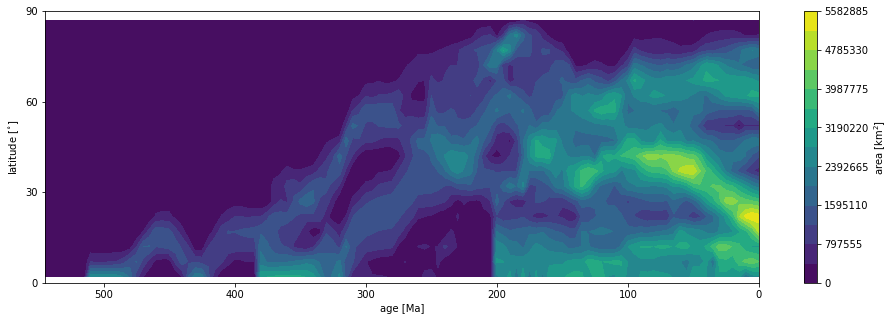

In [24]:
plot_abs_contourf(abs_areas_LIPs_df)

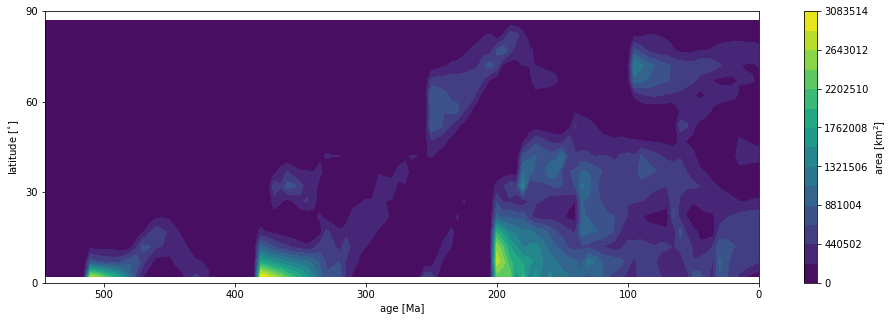

In [25]:
plot_abs_contourf(abs_areas_LIPs_decay1_df)

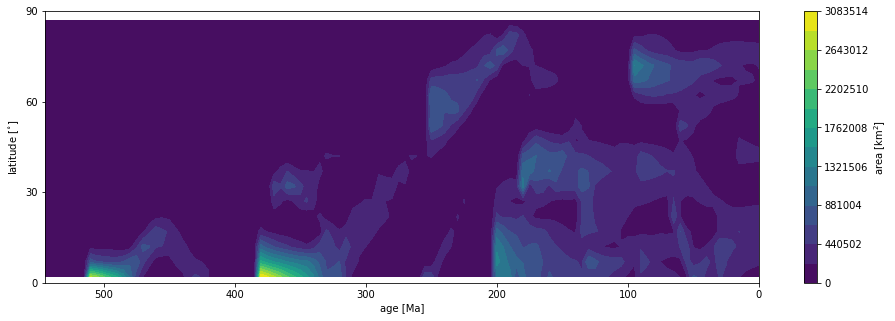

In [26]:
plot_abs_contourf(abs_areas_LIPs_cover1_df)

In [27]:
def plot_within_eq(df):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), gridspec_kw={'height_ratios':[1,7,7]})

    ##### LINES
    ax[1].plot(ts, df.loc[0][3:],
               c='C0', label='within ' + str(band_width) + '$^{\circ}$ of equator')

    ax[1].plot(ts, df.loc[0][3:]+df.loc[1][3:],
               c='C1', label='within ' + str(band_width*2) + '$^{\circ}$ of equator')

    ax[1].plot(ts, df.loc[0][3:]+df.loc[1][3:]+df.loc[2][3:],
               c='C2', label='within ' + str(band_width*3) + '$^{\circ}$ of equator')

    ax[1].invert_xaxis()
    ax[1].set_ylabel('area [km$^{2}$]')
    ax[1].set_xticklabels([])
    ax[1].legend()
    
    ##### CONTOURF
    ax[2].set_xlim(ax[1].get_xlim())
    ax[2].set_ylim(0,90)
    ax[2].set_yticks([0,30,60,90])
    ax[2].set_xlabel('age [Ma]')
    ax[2].set_ylabel('absolute latitude')

    just_values = df.values[:,3:]

    levels = np.linspace(np.min(just_values),np.max(just_values),15)

    cntrf = ax[2].contourf(ts, df['lat_mids'], just_values, cmap='viridis', levels=levels)
    
    cbar_position = fig.add_axes([0.93,0.15,0.02,0.25])

    cbar = fig.colorbar(cntrf, cax=cbar_position)
    cbar.ax.set_ylabel('area [km$^{2}$]')
    
    ##### GLACIAL PATCHES
    ax[0].set_xlim(ax[1].get_xlim())
    ax[0].set_xticklabels([])
    ax[0].set_ylim(0,1)
    ax[0].set_yticks([])

    #Hirnantian glaciation (455 to 435 Ma)
    Hirnantian = patches.Rectangle((435,0),20,1,edgecolor='none',facecolor='#447CC0')
    ax[0].add_patch(Hirnantian)
    #Late Paleozoic ice age (320 to 280 Ma)
    LPIA = patches.Rectangle((280,0),40,1,edgecolor='none',facecolor='#447CC0')
    ax[0].add_patch(LPIA)
    #Cenozoic glaciation (35 to 0 Ma)
    Cenozoic = patches.Rectangle((0,0),35,1,edgecolor='none',facecolor='#447CC0')
    ax[0].add_patch(Cenozoic)
    ax[0].text(ax[1].get_xlim()[0]*1.003,0.5,
               'glacial\nintervals',verticalalignment='center',horizontalalignment='right',color='#447CC0')

    plt.show(fig)

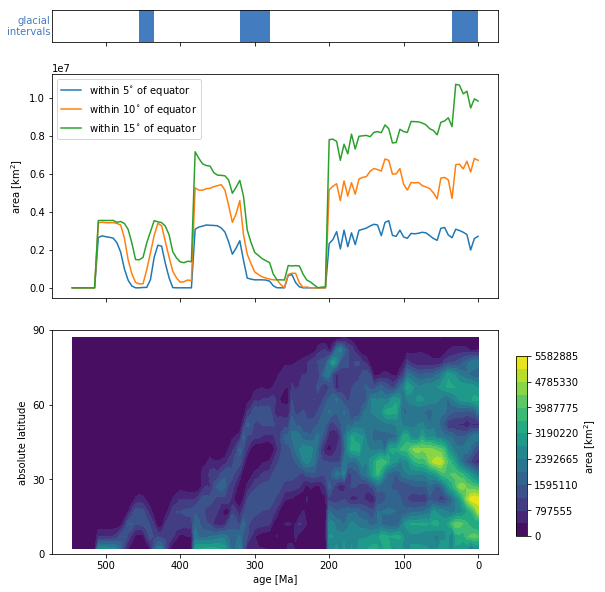

In [28]:
plot_within_eq(abs_areas_LIPs_df)

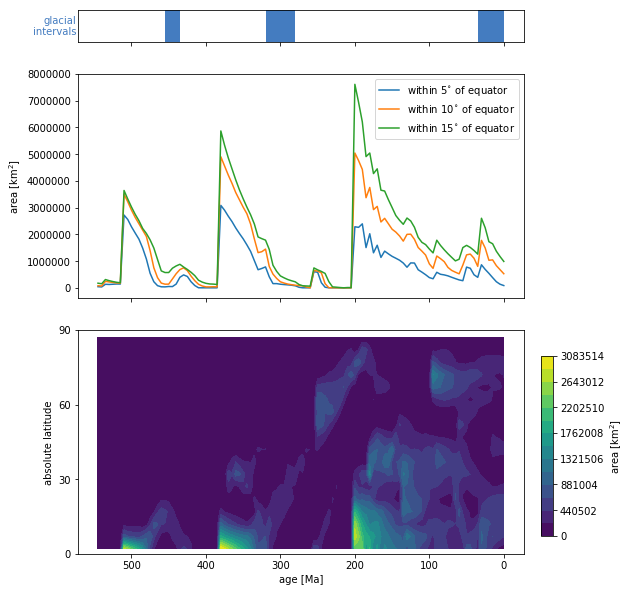

In [29]:
plot_within_eq(abs_areas_LIPs_decay1_df)

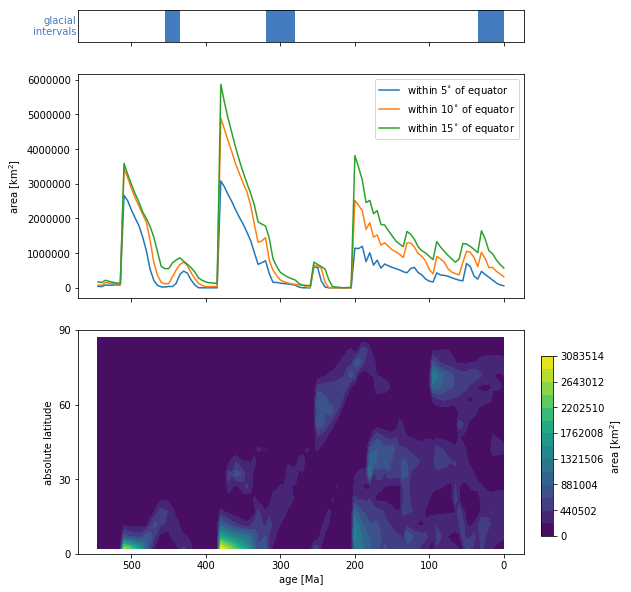

In [30]:
plot_within_eq(abs_areas_LIPs_cover1_df)

### Centroids

In [31]:
LIP_properties.sort_values(by='begins', inplace=True)
LIP_properties.reset_index(drop=True, inplace=True)
LIP_properties[LIP_properties['begins']<520]

,Ids,areas,begins,names
0,GPlates-da0f74a2-aa63-4485-9bf6-4a9545145637,6.745086e+05,16.0,Columbia River
1,GPlates-5d75bc78-2713-44d2-81a4-005de743e10a,6.291461e+05,30.0,Afar
2,GPlates-fbaf88f9-f9e0-4145-8bdc-6806d3698089,1.404938e+06,30.0,Afar
3,GPlates-23c08e9a-bd02-4dc9-92ef-02f2e1de524f,2.526845e+05,62.0,NAIP
4,GPlates-f2022fc4-9474-4a5e-b080-1518e906d269,8.196279e+05,62.0,NAIP
5,GPlates-c8d44615-95f7-4ed1-89df-21f9b6d2d433,8.254353e+05,66.0,Deccan
6,GPlates-863be4af-a629-44fd-b76f-5400dcab579f,4.523263e+05,66.0,Seychelles
7,GPlates-cb3c8e35-d06f-498a-817c-abd7c93ba9a9,6.226795e+05,90.0,Madagascar
8,GPlates-cbc9866c-5138-4faf-a83d-45e09165a503,1.067234e+05,94.0,Caribbean-Colombian
9,GPlates-dc3821e8-91d6-4e0d-9d6c-79eae82bad92,5.930097e+03,94.0,Caribbean-Colombian


In [32]:
emplacement_lat = np.array([])
emplacement_area = np.array([])
emplacement_age = np.array([])
emplacement_name = []

multipolygons = ['Afar','NAIP','Caribbean-Colombian','HALIP','Parana-Etendeka','Ferrar','CAMP','Tarim']
multipolygons_lat = [11.6301,62.3749,-0.6249,78.1555,-26.1849,-58.7390,0.4810,34.9304]

# first deal with single polygons
for i in range(len(LIP_properties.index)):
    if LIP_properties['begins'][i] < 520:
        if LIP_properties['names'][i] not in multipolygons:
            emplacement_name.append(LIP_properties['names'][i])
            emplacement_area = np.append(emplacement_area, LIP_properties['areas'][i])
            emplacement_age = np.append(emplacement_age, LIP_properties['begins'][i])

            row = centroid_lat_LIPs_df[centroid_lat_LIPs_df['LIP_Ids']==LIP_properties['Ids'][i]].values[0,2:]

            for j in range(len(row)):
                if np.isnan(row[j]):
                    pass
                else:
                    ind = j
                    break

            emplacement_lat = np.append(emplacement_lat, row[j])
            
# now deal with multipolygons manually
for i in range(len(multipolygons)):
    this_LIP = LIP_properties[LIP_properties['names']==multipolygons[i]]
    emplacement_name.append(multipolygons[i])
    emplacement_lat = np.append(emplacement_lat, multipolygons_lat[i])
    emplacement_area = np.append(emplacement_area, np.sum(this_LIP['areas']))
    emplacement_age = np.append(emplacement_age, np.mean(this_LIP['begins']))
    
# sort by area to make sure we see all points
sort_inds = np.argsort(emplacement_area)[::-1]
emplacement_area = emplacement_area[sort_inds]
emplacement_age = emplacement_age[sort_inds]
emplacement_lat = emplacement_lat[sort_inds]
emplacement_name = [emplacement_name[i] for i in sort_inds]

# make dataframe
emplacement_df = pd.DataFrame({'area':emplacement_area,
                               'age':emplacement_age,
                               'lat':emplacement_lat,
                               'name':emplacement_name})
emplacement_df.sort_values(by='age',inplace=True)
emplacement_df.reset_index(drop=True, inplace=True)
emplacement_df

,age,area,lat,name
0,16.0,6.745086e+05,44.316255,Columbia River
1,30.0,2.034084e+06,11.630100,Afar
2,62.0,1.072312e+06,62.374900,NAIP
3,66.0,4.523263e+05,-31.285212,Seychelles
4,66.0,8.254353e+05,-23.703433,Deccan
5,90.0,6.226795e+05,-39.553553,Madagascar
6,94.0,7.062814e+05,-0.624900,Caribbean-Colombian
7,95.0,3.558983e+06,78.155500,HALIP
8,131.0,6.546929e+05,-7.207815,EQUAMP
9,132.0,3.149479e+04,-64.065370,Bunbury


### Figures

In [33]:
print(halflife)
print(cover_removal)
print(cover_halflife)

[36, 120]
[False, False, True, True]
[36, 120, 36, 120]


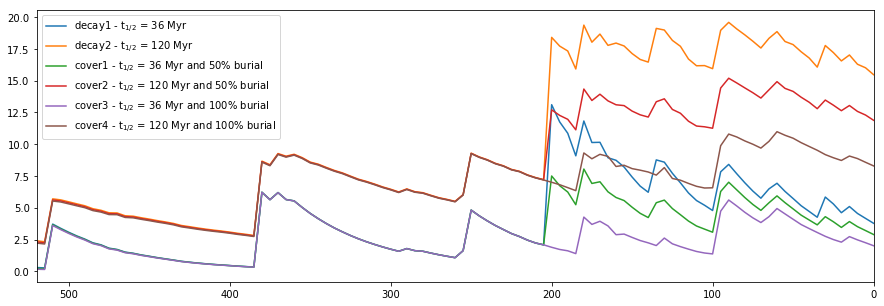

In [34]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(ts, np.sum(abs_areas_LIPs_decay1_df.values[:,3:]/1e6, axis=0), label='decay1 - t$_{1/2}$ = 36 Myr')
ax.plot(ts, np.sum(abs_areas_LIPs_decay2_df.values[:,3:]/1e6, axis=0), label='decay2 - t$_{1/2}$ = 120 Myr')
ax.plot(ts, np.sum(abs_areas_LIPs_cover1_df.values[:,3:]/1e6, axis=0), label='cover1 - t$_{1/2}$ = 36 Myr and 50% burial')
ax.plot(ts, np.sum(abs_areas_LIPs_cover2_df.values[:,3:]/1e6, axis=0), label='cover2 - t$_{1/2}$ = 120 Myr and 50% burial')
ax.plot(ts, np.sum(abs_areas_LIPs_cover3_df.values[:,3:]/1e6, axis=0), label='cover3 - t$_{1/2}$ = 36 Myr and 100% burial')
ax.plot(ts, np.sum(abs_areas_LIPs_cover4_df.values[:,3:]/1e6, axis=0), label='cover4 - t$_{1/2}$ = 120 Myr and 100% burial')
ax.set_xlim(520,0)
ax.legend()

plt.show(fig)

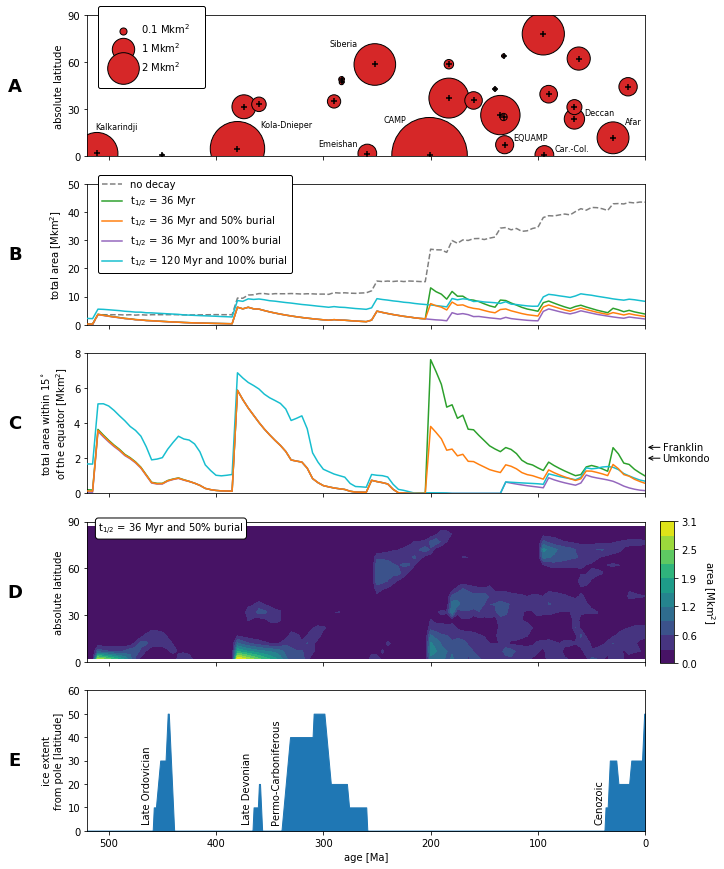

In [35]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,15), sharex=True)

### LIP centroids

scatter_size_ratio = 0.0005
scatter_size = emplacement_area*scatter_size_ratio
ax[0].scatter(emplacement_age, np.abs(emplacement_lat),s=scatter_size,
              facecolor='C3',edgecolor='k')
ax[0].scatter(emplacement_age, np.abs(emplacement_lat),marker='+',c='k')
ax[0].set_ylim(0,90)
ax[0].set_yticks([0,30,60,90])
ax[0].set_ylabel('absolute latitude')
l1 = ax[0].scatter([],[], s=100000*scatter_size_ratio, facecolor='C3', edgecolor='k')
l2 = ax[0].scatter([],[], s=1000000*scatter_size_ratio, facecolor='C3', edgecolor='k')
l3 = ax[0].scatter([],[], s=2000000*scatter_size_ratio, facecolor='C3', edgecolor='k')
box = ax[0].get_position()
labels = ['0.1 Mkm$^{2}$', '1 Mkm$^{2}$', '2 Mkm$^{2}$']
ax[0].text(513, 19, 'Kalkarindji', fontsize=8,
           horizontalalignment='left',verticalalignment='center')
ax[0].text(359, 20, 'Kola-Dnieper', fontsize=8,
           horizontalalignment='left',verticalalignment='center')
ax[0].text(268, 8, 'Emeishan', fontsize=8,
           horizontalalignment='right',verticalalignment='center')
ax[0].text(268, 72, 'Siberia', fontsize=8,
           horizontalalignment='right',verticalalignment='center')
ax[0].text(223, 23, 'CAMP', fontsize=8,
           horizontalalignment='right',verticalalignment='center')
ax[0].text(123, 12, 'EQUAMP', fontsize=8,
           horizontalalignment='left',verticalalignment='center')
ax[0].text(85, 5, 'Car.-Col.', fontsize=8,
           horizontalalignment='left',verticalalignment='center')
ax[0].text(57, 28, 'Deccan', fontsize=8,
           horizontalalignment='left',verticalalignment='center')
ax[0].text(19, 22, 'Afar', fontsize=8,
           horizontalalignment='left',verticalalignment='center')
ax[0].legend([l1, l2, l3], labels, 
             borderpad=1.5,edgecolor='k',facecolor='white',loc='upper left',bbox_to_anchor=(0.01,1.1),framealpha=1)
ax[0].text(-0.13, 0.5, 'A', fontweight='bold', fontsize=18,
           horizontalalignment='center',verticalalignment='center',transform=ax[0].transAxes)

### TOTAL LIPs

ax[1].plot(ts, np.sum(abs_areas_LIPs_df.values[:,3:]/1e6, axis=0) - np.sum(abs_areas_LIPs_df['area_km2_520']/1e6),
           c='C7', ls='--', label='no decay', zorder=0)
ax[1].plot(ts, np.sum(abs_areas_LIPs_decay1_df.values[:,3:]/1e6, axis=0),
           c='C2', label='t$_{1/2}$ = 36 Myr', zorder=1)
ax[1].plot(ts, np.sum(abs_areas_LIPs_cover1_df.values[:,3:]/1e6, axis=0),
           c='C1', label='t$_{1/2}$ = 36 Myr and 50% burial', zorder=4)
ax[1].plot(ts, np.sum(abs_areas_LIPs_cover3_df.values[:,3:]/1e6, axis=0),
           c='C4', label='t$_{1/2}$ = 36 Myr and 100% burial', zorder=2)
ax[1].plot(ts, np.sum(abs_areas_LIPs_cover4_df.values[:,3:]/1e6, axis=0),
           c='C9', label='t$_{1/2}$ = 120 Myr and 100% burial', zorder=3)
ax[1].set_ylim(0,50)
ax[1].set_ylabel('total area [Mkm$^{2}$]')
ax[1].legend(edgecolor='k',facecolor='white',loc='upper left',bbox_to_anchor=(0.01,1.1),framealpha=1)
ax[1].text(-0.13, 0.5, 'B', fontweight='bold', fontsize=18,
           horizontalalignment='center',verticalalignment='center',transform=ax[1].transAxes)

### TROPICAL LIPs

ax[2].plot(ts, np.sum(abs_areas_LIPs_decay1_df.values[:3,3:]/1e6, axis=0),
           c='C2', label='t$_{1/2}$ = 36 Myr', zorder=1)
ax[2].plot(ts, np.sum(abs_areas_LIPs_cover1_df.values[:3,3:]/1e6, axis=0),
           c='C1', label='t$_{1/2}$ = 36 Myr and 50% burial', zorder=4)
ax[2].plot(ts, np.sum(abs_areas_LIPs_cover3_df.values[:3,3:]/1e6, axis=0),
           c='C4', label='t$_{1/2}$ = 36 Myr and 100% burial', zorder=2)
ax[2].plot(ts, np.sum(abs_areas_LIPs_cover4_df.values[:3,3:]/1e6, axis=0),
           c='C9', label='t$_{1/2}$ = 120 Myr and 100% burial', zorder=3)
ax[2].set_ylim(0,8)
ax[2].set_ylabel('total area within 15$^{\circ}$\nof the equator [Mkm$^{2}$]')
ax[2].text(-0.13, 0.5, 'C', fontweight='bold', fontsize=18,
           horizontalalignment='center',verticalalignment='center',transform=ax[2].transAxes)

Franklin_y = ((2620997.0487505244)/1e6)/8
ax[2].annotate('', xy=(1.001, Franklin_y), xycoords='axes fraction', xytext=(1.03, Franklin_y), 
               arrowprops=dict(arrowstyle="->", color='k'))
ax[2].text(1.031, Franklin_y, 'Franklin', fontsize=10,
           horizontalalignment='left',verticalalignment='center',transform=ax[2].transAxes)
Umkondo_y = ((2002627.6139613984)/1e6)/8
ax[2].annotate('', xy=(1.001, Umkondo_y), xycoords='axes fraction', xytext=(1.03, Umkondo_y), 
               arrowprops=dict(arrowstyle="->", color='k'))
ax[2].text(1.031, Umkondo_y, 'Umkondo', fontsize=10,
           horizontalalignment='left',verticalalignment='center',transform=ax[2].transAxes)

### HEAT MAP FOR BURIAL + DECAY

values = abs_areas_LIPs_cover1_df.values[:,3:]/1e6
levels = np.linspace(np.min(values),np.max(values),11)
cntrf = ax[3].contourf(ts, abs_areas_LIPs_cover1_df['lat_mids'], values, cmap='viridis', levels=levels)
cbar_position = fig.add_axes([0.92,0.28,0.02,0.132])
cbar = fig.colorbar(cntrf, cax=cbar_position)
cbar.set_ticks(np.linspace(np.min(values),np.max(values),6))
cbar.set_ticklabels(np.round(np.linspace(np.min(values),np.max(values),6),1))
cbar.ax.set_ylabel('area [Mkm$^{2}$]', rotation=270, labelpad=20)
ax[3].set_ylabel('absolute latitude')
ax[3].set_yticks([0,30,60,90])
ax[3].text(0.02, 0.95, 't$_{1/2}$ = 36 Myr and 50% burial',
           bbox=dict(facecolor='white', edgecolor='k', boxstyle='round'),
           horizontalalignment='left',verticalalignment='center',transform=ax[3].transAxes)
ax[3].text(-0.13, 0.5, 'D', fontweight='bold', fontsize=18,
           horizontalalignment='center',verticalalignment='center',transform=ax[3].transAxes)

### ICE EXTENT

ax[4].fill_between(ice['AGE (MA)'], ice['LATITUDE FROM POLE'], color='C0')
ax[4].set_xlabel('age [Ma]')
ax[4].set_ylabel('ice extent\nfrom pole [latitude]')
ax[4].set_ylim(0,60)
ax[4].text(464, 3, 'Late Ordovician', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')
ax[4].text(371, 3, 'Late Devonian', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')
ax[4].text(344, 3, 'Permo-Carboniferous', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')
ax[4].text(43, 3, 'Cenozoic', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')
ax[4].text(-0.13, 0.5, 'E', fontweight='bold', fontsize=18,
           horizontalalignment='center',verticalalignment='center',transform=ax[4].transAxes)

### prettify

ax[4].set_xlim(520,0)

#plt.savefig('../Manuscript/Figures/LIP_Areas.pdf', bbox_inches='tight')
plt.show(fig)

### Reconstruction Snapshots

Plot the reconstruction at times that correspond to peaks in LIP area in the tropics:

* **510 Ma** : emplacement of the Kalkarindji LIP into the tropics
* **370 Ma** : emplacement of the Kola-Dnieper LIP into the tropics
* **200 Ma** : emplacement of the CAMP into the tropics
* **30 Ma** : emplacement of the Afar into the tropics and drift of the Deccan through the tropics

A version where we represent age with changing opacity:

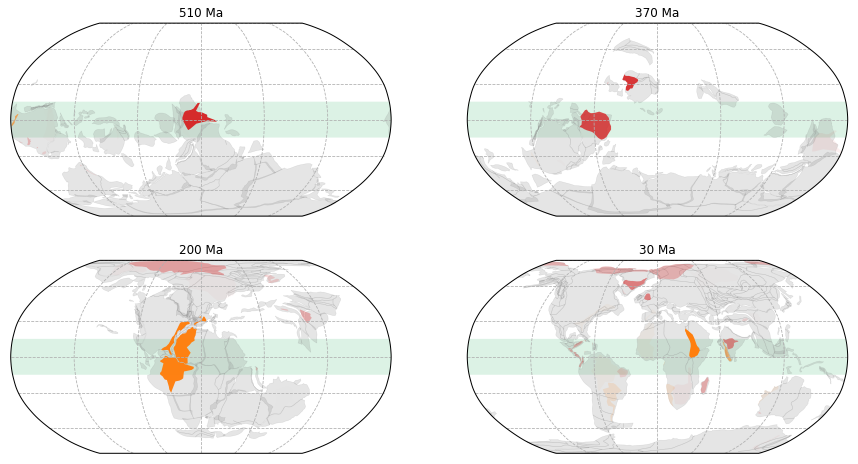

In [51]:
# set up the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8), subplot_kw=dict(projection=ccrs.Robinson()))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].set_global()
    ax[i].gridlines(xlocs=np.arange(-180,181,60),ylocs=np.arange(-90,91,30),linestyle='--')

# the snapshots we want
snapshot_ts = [510, 370, 200, 30]

# the decay model
snapshot_halflife = 36
snapshot_lamb = np.log(2)/snapshot_halflife

# loop over the snapshots
for i in range(len(snapshot_ts)):
    
    # add tropics patch
    ax[i].add_patch(patches.Rectangle(xy=[-180, -15], width=360, height=30,
                                      facecolor='#52BE80',
                                      alpha=0.2,
                                      transform=ccrs.PlateCarree()))
    
    # get the time
    t = snapshot_ts[i]
    
    # perform the reconstruction for the cratons and LIPs
    reconstructed_cratons = []
    pygplates.reconstruct(craton_feature_collection, model, reconstructed_cratons, t, anchor)
    reconstructed_LIPs = []
    pygplates.reconstruct(LIP_feature_collection, model, reconstructed_LIPs, t, anchor)
    
    # plot the cratons
    plot_reconstructed_features(ax[i], reconstructed_cratons, color='grey', linewidth=0.5, alpha=0.2)
    
    # iterate through the LIPs
    for j in range(len(reconstructed_LIPs)):
        
        # pull out lat/lon vertices
        lat_lon_array = reconstructed_LIPs[j].get_reconstructed_geometry().to_lat_lon_array()
        lats = lat_lon_array[:,0]
        lons = lat_lon_array[:,1]

        # polygons need to be drawn counter clockwise to be drawn properly if they cross the dateline
        if reconstructed_LIPs[j].get_reconstructed_geometry().get_orientation() == pygplates.PolygonOnSphere.Orientation.clockwise:
            lats = np.flip(lats)
            lons = np.flip(lons)
            
        # get the eruption age, reconstruction age, feature age, and feature name
        begin_date, end_date = reconstructed_LIPs[j].get_feature().get_valid_time()
        now_date = reconstructed_LIPs[j].get_reconstruction_time()
        feature_age = begin_date - now_date
        feature_name = reconstructed_LIPs[j].get_feature().get_name()
        
        # covered LIPs
        if feature_name in covered_LIP_names:
            facecolor = 'C1'
            decay_ratio = np.exp(-snapshot_lamb*feature_age)
        
        # all other LIPs
        else:
            facecolor = 'C3'
            decay_ratio = np.exp(-snapshot_lamb*feature_age)
            
        # plot the LIP
        poly = Polygon(zip(lons,lats))
        ax[i].add_geometries([poly], ccrs.Geodetic(), facecolor=facecolor, alpha=decay_ratio)
        
        # add title
        ax[i].set_title(str(snapshot_ts[i]) + ' Ma')
        
plt.show(fig)

### Present and Original Extent Shapefiles

This takes a minute or two to run!

In [36]:
# get names of shapefiles
plot_original_A = root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/LIP_Outline_edited_plot_0_520.shp'
plot_original_B = root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/LIP_Outline_edited_plot_520_1300.shp'

plot_present_A = root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/LIP_current_extent_plot_0_520.shp'
plot_present_B = root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/LIP_current_extent_plot_520_1300.shp'

plot_CEED6 = root+'Paleogeo_models/CEED6/CEED6_POLY.shp'

error: unpack requires a string argument of length 276560

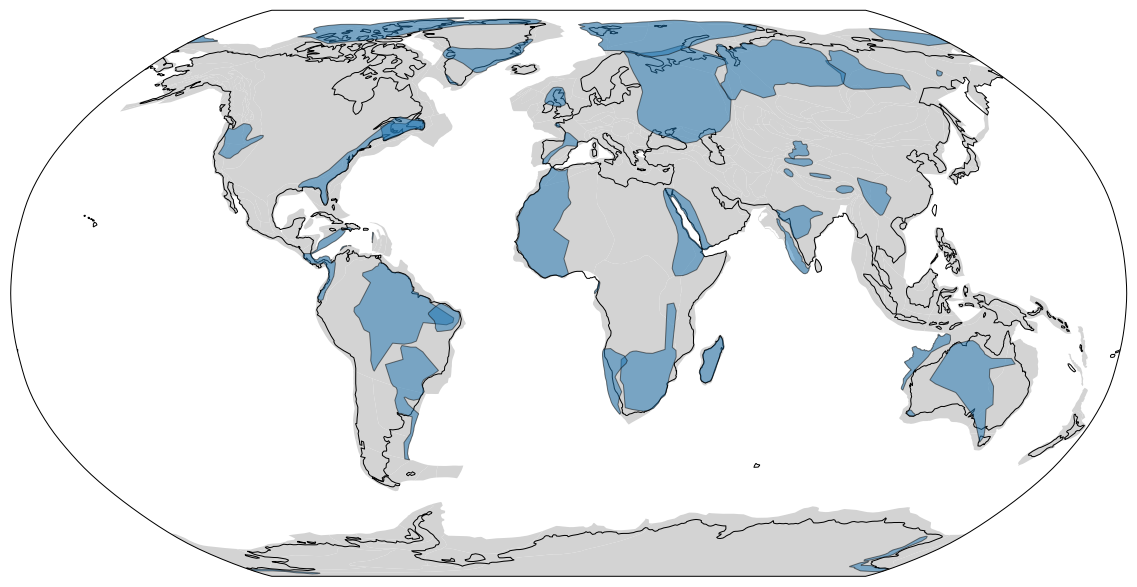

In [37]:
# set up figure and axis
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.Robinson())

# plot CEED6
shape_feature = ShapelyFeature(Reader(plot_CEED6).geometries(),
                               ccrs.PlateCarree(), edgecolor='none', facecolor='lightgrey')
ax.add_feature(shape_feature)

# coastlines
ax.coastlines(color='black')

# plot original polygons
shape_feature = ShapelyFeature(Reader(plot_original_A).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='C0', alpha=0.5)
ax.add_feature(shape_feature)

# plot present polygons
shape_feature = ShapelyFeature(Reader(plot_present_A).geometries(),
                               ccrs.PlateCarree(), edgecolor='none', facecolor='C1')
ax.add_feature(shape_feature)

#plt.savefig('../Manuscript/Figures/LIP_Map_0_520.pdf')
plt.show()

In [ ]:
# set up figure and axis
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.Robinson())

# plot CEED6
shape_feature = ShapelyFeature(Reader(plot_CEED6).geometries(),
                               ccrs.PlateCarree(), edgecolor='none', facecolor='lightgrey')
ax.add_feature(shape_feature)

# coastlines
ax.coastlines(color='black')

# plot original polygons
shape_feature = ShapelyFeature(Reader(plot_original_B).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='C0', alpha=0.5)
ax.add_feature(shape_feature)

# plot present polygons
shape_feature = ShapelyFeature(Reader(plot_present_B).geometries(),
                               ccrs.PlateCarree(), edgecolor='none', facecolor='C1')
ax.add_feature(shape_feature)

#plt.savefig('../Manuscript/Figures/LIP_Map_520_1300.pdf')
plt.show()

### Table of Data

In [ ]:
output_df = pd.DataFrame(columns=['age (Ma)',
                                  'ice extent',
                                  'total',
                                  'within 15',
                                  'decay36 total',
                                  'decay36 within 15',
                                  'decay120 total',
                                  'decay120 within 15',
                                  'decay36_burial50 total',
                                  'decay36_burial50 within 15',
                                  'decay120_burial50 total',
                                  'decay120_burial50 within 15',
                                  'decay36_burial100 total',
                                  'decay36_burial100 within 15',
                                  'decay120_burial100 total',
                                  'decay120_burial100 within 15'])

output_df['age (Ma)'] = ts

output_df['total'] = np.sum(abs_areas_LIPs_df.values[:,3:], axis=0)
output_df['within 15'] = np.sum(abs_areas_LIPs_df.values[:3,3:], axis=0)

output_df['decay36 total'] = np.sum(abs_areas_LIPs_decay1_df.values[:,3:], axis=0)
output_df['decay36 within 15'] = np.sum(abs_areas_LIPs_decay1_df.values[:3,3:], axis=0)

output_df['decay120 total'] = np.sum(abs_areas_LIPs_decay2_df.values[:,3:], axis=0)
output_df['decay120 within 15'] = np.sum(abs_areas_LIPs_decay2_df.values[:3,3:], axis=0)

output_df['decay36_burial50 total'] = np.sum(abs_areas_LIPs_cover1_df.values[:,3:], axis=0)
output_df['decay36_burial50 within 15'] = np.sum(abs_areas_LIPs_cover1_df.values[:3,3:], axis=0)

output_df['decay120_burial50 total'] = np.sum(abs_areas_LIPs_cover2_df.values[:,3:], axis=0)
output_df['decay120_burial50 within 15'] = np.sum(abs_areas_LIPs_cover2_df.values[:3,3:], axis=0)

output_df['decay36_burial100 total'] = np.sum(abs_areas_LIPs_cover3_df.values[:,3:], axis=0)
output_df['decay36_burial100 within 15'] = np.sum(abs_areas_LIPs_cover3_df.values[:3,3:], axis=0)

output_df['decay120_burial100 total'] = np.sum(abs_areas_LIPs_cover4_df.values[:,3:], axis=0)
output_df['decay120_burial100 within 15'] = np.sum(abs_areas_LIPs_cover4_df.values[:3,3:], axis=0)

output_df = output_df[output_df['age (Ma)']<=520]
output_df.reset_index(drop=True, inplace=True)

ts_520 = np.arange(520,-5,-5)
ice_5Myr = np.zeros(len(ts_520))
for i in range(len(ts_520)):
    ice_5Myr[i] = ice[ice['AGE (MA)']==ts_520[i]]['LATITUDE FROM POLE']
output_df['ice extent'] = ice_5Myr

output_df.to_csv('reconstruction_output/summary_output.csv', index=False)
output_df.to_csv('reconstruction_output/summary_output.txt', index=False, header=False)